In [1]:
########################################
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import os
import time

########################################
#PARAMETERS
nTimeSteps = 60 #at 60 Hz
print(f'nTimeSteps: {nTimeSteps}')
samplenum = 1
hiddenlayers = [100]
use_case = 'cube-drag'
input_size = 25 # target (0:3), q (3:9), qdot (9:15), qddot (15:21), p_now (21:25) 
sample_file_path = f'/Users/nicovonau/Code/thesis_pytorch/Data/Samples/data_cube-drag_{nTimeSteps}tsteps_2315/'
simulation_file_path = '/Users/nicovonau/Code/thesis_pytorch/Data/Simulations/cube-drag.sim'
objective_file_path = '/Users/nicovonau/Code/thesis_pytorch/Data/Objectives/cube-drag.obj'

# set log level
dde.set_log_level(dde.LogLevel.off)

# check dde version
print("using dde version: " + dde.__version__)

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
torch.set_default_dtype(torch.double)
torch.set_printoptions(precision=6)

#######################################
# LOAD SIMULATION AND OBJECTIVE FUNCTION
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)
dyn_json = json.load(open(simulation_file_path))

# Objective Function
obj = dde.InverseObjective(dyn)
obj.loadFile(objective_file_path)
objective_json = json.load(open(objective_file_path))
opt = dde.Newton()

##########################################
#SAMPLE TARGETS
y_target = np.zeros((samplenum,3))
y_target[:,2] = np.random.rand(samplenum)/2
y_target[:,1] = 0.0268342693608721
y_target[:,0] = np.random.rand(samplenum)/2
print("done")

###################################
#USE P FROM TRAJ_OPT
output_size = dyn.nParameters
input = np.zeros((samplenum,input_size))
p = np.zeros((samplenum, dyn.nParameters*nTimeSteps))
for i in range(samplenum):
    objective_json["objectives"]["rbTargetPositions"][0]["timeIndex"] = nTimeSteps-1
    objective_json["objectives"]["rbTargetPositions"][0]["targetPos"] = ([[y_target[i,0]],[y_target[i,1]],[y_target[i,2]]]) 
    obj.loadJson(objective_json)
    p[i,:] = opt.minimize(obj, p_init)
    input[i, 0:3] = y_target[i,:]
    input[i, 3:9] = dyn.q0
    input[i, 9:15] = dyn.qdot0
    input[i, 15:21] = dyn.qddot0
    input[i, 21:25] = dyn.p0

#p = torch.tensor(p, requires_grad = True)
#input = torch.tensor(input, requires_grad = True)

###################################
#USE P FROM P0
dev = 0.01
for i in range(samplenum):
    p[i, :] = p_init + (i*dev)

p = torch.tensor(p, requires_grad = True)
print(f'Shape of p: {p.shape}')
print(f'Shape of input: {input.shape}')

nTimeSteps: 60
using dde version: v0.1.2-20-g1cc6119-dirty
done
Shape of p: torch.Size([1, 240])
Shape of input: (1, 25)


In [6]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-6

with open(sample_file_path + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q_target'])
samplenum = filesize*number_of_files
input = np.zeros((samplenum, input_size))
p= np.zeros((samplenum, 4*nTimeSteps))
for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:9] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 9:15] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 15:21] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 21:25] = np.array(p_now_i)
        for i, p_i in enumerate(data['p']):
            p[filenum*filesize+i, :] = np.array(p_i)

print(f'Shape of input: {input.shape}')
#Remove zeros
input = input[~(input == 0).all(1)]
print(f'after removing zeros: {input.shape}')
p = torch.tensor(p[2, :], requires_grad = True)

data= input[2, :]
#samplenum = len(data[:,0])
print(data.shape)

Shape of input: (15000, 25)
after removing zeros: (15000, 25)
(25,)


In [4]:
#########################################
#LOAD SINGLE FILES
input = np.zeros((1, input_size))
p= np.zeros((samplenum, 4*nTimeSteps))

with open('q_nan_60.q0') as json_file:
    data = json.load(json_file)
    for i, q_i in enumerate(data['q0']):
        input[0, 3:9] = np.array(q_i)
    for i, qdot_i in enumerate(data['qdot0']):
        input[0, 9:15] = np.array(qdot_i)
    for i, qddot_i in enumerate(data['qddot0']):
        input[0, 15:21] = np.array(qddot_i)
with open('p_nan_60.p') as json_file:
    data = json.load(json_file)
    for i, p_i in enumerate(data['parameters']):
        p[0, :] = np.array(p_i)

print(f'Shape of input: {input.shape}')
#Remove zeros
data = input[~(input == 0).all(1)]
print(f'after removing zeros: {input.shape}')
p = torch.tensor(p, requires_grad = True)

samplenum = len(data[:,0])
print(data.shape)


Shape of input: (1, 25)
after removing zeros: (1, 25)
(1, 25)


In [5]:
##########################################
#BUILD CUSTOM SIMULATION FUNCTION
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, data_input):
        #print(f'input: {input.shape}')
        p_ = input.detach().clone().numpy()
        bs = len(p[:,0])
        q_pred = torch.ones([len(p_[:, 0]),dyn.nDofs*nTimeSteps])
        for i_f in range(bs):
            dyn.q0 = data_input[i_f, 3:9]
            dyn.qdot0 = data_input[i_f, 9:15]
            dyn.qddot0 = data_input[i_f, 15:21]
            state = dyn.q(p_[i_f,:])
            q_pred[i_f, :] = torch.tensor(state.q)
        #print(f'q_pred: {q_pred.shape}')
        data_input_ = torch.tensor(data_input)
        ctx.save_for_backward(input, data_input_)
        
        return q_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, data_input = ctx.saved_tensors
        p_2 = input.detach().clone().numpy()
        bs_ = len(p_2[:,0])
        data_input_2 = data_input.detach().clone().numpy()
        dq_dp_batch = torch.zeros([dyn.nDofs*nTimeSteps, dyn.nParameters*nTimeSteps])
        for i_b in range(bs_):
            dyn.q0 = data_input_2[i_b, 3:9]
            dyn.qdot0 = data_input_2[i_b, 9:15]
            dyn.qddot0 = data_input_2[i_b, 15:21]
            state = dyn.q(p_2[i_b, :])
            dq_dp = dyn.dq_dp(state, p_2[i_b, :])
            dq_dp = torch.tensor(dq_dp)
            dq_dp_batch = dq_dp_batch + dq_dp
            #dq_dp_batch= torch.clamp(dq_dp_batch, -1000000, 1000000)
            #print(f'dqdp_batch: {dq_dp_batch.shape}')
        #print(f'dqdp: {dq_dp_batch}')
        #dq_dp_batch = dq_dp_batch + e-10
        #print(f'grad_out: {grad_output}')
        #print(f'dq/dp_batch: {dy_dp_batch/samplenum}')
        #print(f'gradout: {grad_output}')
        test = dq_dp_batch/bs_
        #print(test.shape)
        #print(test)
        grad_input = grad_output.mm(test)
        #print(f'shape of grad input: {grad_input}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input, None

Simulate = Simulate.apply
print("Function built")

Function built


In [6]:
################################
#GET ANALYTICAL GRADIENT

print("GETTING ANALYTICAL GRADIENT...")
# Error for whole simulation
from numpy import linalg as LA

q = Simulate(p, input)
grad_output = torch.ones([samplenum,dyn.nDofs*nTimeSteps])
q.backward(grad_output)
dq_dp = p.grad
analytical_grad = dq_dp.clone().detach()
print(f'dy_dp shape = {dq_dp.shape}')
#print(f'dy_dp = {dq_dp}')

GETTING ANALYTICAL GRADIENT...
dy_dp shape = torch.Size([1, 240])


In [7]:
################################
#GET NUMERICAL GRADIENT WITH DIFFERENT PERTUBATIONS
print("GETTING NUMERICAL GRADIENT...")
#dy_dp_FD = np.zeros((3,len(dyn.p_init)))
FD = [5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7, 5e-8, 1e-8, 5e-9, 1e-9, 5e-10, 1e-10]
d = 1e-3
# FD = [d]
#FD = np.logspace(np.log10(0.00000001),np.log10(0.001),num = 50)
Grads = {}
Err = {}
Errors = []
for f, h in enumerate(FD):
    dq_dp_FD = np.zeros((dyn.nDofs*nTimeSteps,dyn.nParameters*nTimeSteps))
    grad_i = np.zeros((dyn.nDofs*nTimeSteps,dyn.nParameters*nTimeSteps))
    for s in range(samplenum):
        input_ = input[s, :]
        for l in range(dyn.nDofs):
            dyn_json["simulation"]["q"][l] = [input_[3+l]] 
            dyn_json["simulation"]["qdot"][l] = [input_[9+l]] 
            dyn_json["simulation"]["qddot"][l] = [input_[15+l]] 
        for l in range(dyn.nParameters):
            dyn_json["simulation"]["p"][l] = [input_[21+l]] 
        dyn.loadJson(dyn_json, nTimeSteps)
        for i in range(nTimeSteps*dyn.nParameters):
            pp= p.clone().detach()
            pm= p.clone().detach()
            pp[s,i] = pp[s,i] + h
            pm[s,i] = pm[s,i] - h
            statep = dyn.q(pp[s, :])
            statem = dyn.q(pm[s, :])
            qp = statep.q
            qm = statem.q
            # print("ym")
            # print(ym)
            # print("yp")
            # print(yp)
            grad_i[:,i] = (qp - qm) / (2 * h)
        dq_dp_FD = dq_dp_FD + grad_i
    dq_dp_FD_ten = torch.tensor(dq_dp_FD)
    #print(f'FD_grad: {dq_dp_FD_ten}')

    Grads[f] = grad_output.mm(dq_dp_FD_ten/samplenum)
    numerical_grad = grad_output.mm(dq_dp_FD_ten/samplenum)
    # print(f'p :{p}')
    print("ANAL_GRAD:")
    print(analytical_grad)
    print("NUM_GRAD:")
    print(numerical_grad)
    #print(f' dy_dp_FD at eps {fd} = \n{dy_dp_FD}')
    Error = LA.norm(Grads[f] - analytical_grad)
    Err[h] = Error
    Errors.append(Error)

    
print(f'Error of numerical and analytical gradient: {Err}')

.495149e+13, -6.268859e+11, -4.062809e+11,
         -1.466778e+12, -1.070243e+13, -1.810009e+13, -3.699035e+12,
         -6.012048e+12,  3.030740e+13,  3.001899e+11,  6.479828e+12,
          3.176577e+12, -4.393290e+12, -1.187724e+13,  4.753779e+12,
         -1.606687e+13, -5.915728e+12,  1.585653e+13, -2.410804e+13,
          1.499973e+13, -2.255605e+11, -2.682037e+13, -1.037257e+13,
         -1.048588e+13,  1.772560e+13, -1.444185e+13, -1.824924e+13,
          2.594972e+13, -2.696778e+13, -2.342153e+12, -2.011368e+13,
          2.968656e+13, -2.829280e+12, -3.875151e+12, -2.857877e+13,
         -2.836022e+12, -2.292788e+12, -6.146774e+12,  4.105841e+12,
          2.053752e+13, -7.301914e+12,  2.425066e+12, -9.827137e+12,
         -2.232501e+13, -4.053129e+12,  2.555672e+13,  3.939614e+12,
          1.789139e+12, -7.956779e+12, -3.042981e+13, -2.544655e+13,
          1.527273e+13,  2.598743e+13,  2.348535e+13, -4.295985e+12,
         -1.852620e+13, -4.520447e+12, -2.562373e+13, -4.075

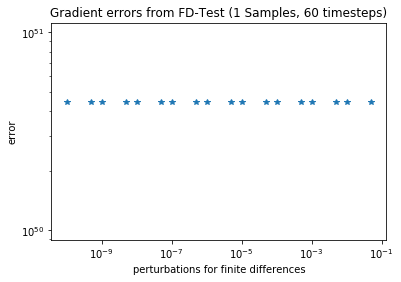

Success


In [8]:
################################
#PLOT ERRORS OVER DIFFERENT PERTURBATIONS

plt.plot(FD, Errors, "*")
plt.xscale('log')
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('perturbations for finite differences')
plt.title(f'Gradient errors from FD-Test ({samplenum} Samples, {nTimeSteps} timesteps)')
plt.savefig(f'/Users/nicovonau/Code/thesis_pytorch/Plots/Gradient_error_{use_case}_{samplenum}batchsz_{nTimeSteps}tsteps2')
plt.show()
print("Success")

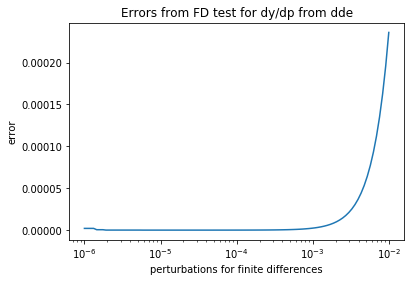

In [134]:
################################
#FD TEST FOR DY/DP FUNCTION

from numpy import linalg as LA
#FD = [1e-2, 1e-3, 1e-4, 1e-5]
#FD = np.linspace(0.000001,0.01, num = 100)
FD = np.logspace(np.log10(0.000001),np.log10(0.01),num = 100)
FDs = []

#Calculate dy_dp with FE
dy_dp = dyn.dy_dp(state_init, dyn.p_init)[-3:, :]
dy_dp_FD = np.zeros((3,len(dyn.p_init)))

for i, fd in enumerate(FD):
    for i in range(len(dyn.p_init)):
        dp= np.zeros(len(dyn.p_init))
        dp[i] = fd
        y_p = dyn.compute(dyn.p_init + dp)
        y_m = dyn.compute(dyn.p_init - dp)
        dy_dp_FD[:, i] = (y_p.y[-3:] - y_m.y[-3:]) / (2* fd)
    err = LA.norm(dy_dp_FD - dy_dp)
    #print(err)
    FDs.append(err)

plt.plot(FD, FDs)
plt.xscale('log')
plt.ylabel('error')
plt.title('Errors from FD test for dy/dp from dde')
plt.xlabel('perturbations for finite differences')
plt.show()